
<img src="srttools.png" width="40%">

Repository: http://github.com/matteobachetti/srt-single-dish-tools

Documentation: http://srt-single-dish-tools.readthedocs.io/en/latest/

# Requirements

You need to install the following libraries as described below:

+ `astropy`

+ `aplpy` for astronomical image visualization, the _development_ version

+ `pandas` and `seaborn` for the example with a pair plot

+ The [`SRT single dish tools`](github.com/matteobachetti/srt-single-dish-tools), of course, with their dependencies.

## Recommended setup

Install [Anaconda](https://www.anaconda.com/download/) then, in a shell:

```
$ conda create -n py3-clean python=3.6 astropy seaborn numpy scipy matplotlib h5py statsmodels pyyaml numba pyregion pandas

$ source activate py3-clean

$ git clone https://github.com/matteobachetti/srt-single-dish-tools

$ cd srt-single-dish-tools

$ pip install .

$ pip install git+https://github.com/aplpy/aplpy.git

```

## Using only pip

Open a shell, then

```
pip install git+https://github.com/matteobachetti/srt-single-dish-tools.git astropy seaborn numpy scipy matplotlib h5py statsmodels pyyaml numba pyregion git+https://github.com/aplpy/aplpy.git pandas
```
And wait some hours for the compilation to complete :)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import print_function, division

from astropy.table import Table
import aplpy
from matplotlib import pyplot as plt

from seaborn import pairplot, lmplot
import warnings
from pandas import read_csv

warnings.filterwarnings('ignore')

# Simulation

We now simulate the observation of a point source and a few calibrator cross scans.

In [2]:
!SDTfake -h

usage: SDTfake [-h] [-s SOURCE_FLUX] [-n NOISE_AMPLITUDE] [-b BASELINE]
               [-g GEOMETRY GEOMETRY GEOMETRY GEOMETRY]
               [--beam-width BEAM_WIDTH] [--spacing SPACING] [-o OUTDIR_ROOT]
               [--scan-speed SCAN_SPEED] [--integration-time INTEGRATION_TIME]
               [--no-cal] [--debug]

Simulate a single scan or a map with a point source.

optional arguments:
  -h, --help            show this help message and exit
  -s SOURCE_FLUX, --source-flux SOURCE_FLUX
                        Source flux in Jy
  -n NOISE_AMPLITUDE, --noise-amplitude NOISE_AMPLITUDE
                        White noise amplitude
  -b BASELINE, --baseline BASELINE
                        Baseline kind: "flat", "slope" (linearly
                        increasing/decreasing), "messy" (random walk) or a
                        number (which gives an amplitude to the random-walk
                        baseline, that would be 20 for "messy")
  -g GEOMETRY GEOMETRY GEOMETRY GEOMETRY, --g

In [3]:
!SDTfake -s 20 -b 2 --spacing 0.3 --geometry 60 60 60 60

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]
Simulating dec scans...
100%|█████████████████████████████████████████| 201/201 [00:47<00:00,  4.19it/s]
Simulating RA scans...
100%|█████████████████████████████████████████| 201/201 [00:47<00:00,  4.24it/s]


# Inspect observations

During a night of observations, we will in general observe a number of calibrators and sources, in random order. Our observation will be split into a series of directories:

In [4]:
!ls sim/

calibrator1 calibrator2 gauss_dec   gauss_ra


Some of these observations might have been done in different bands, or using different receivers, and you might have lost the list of observations (or the user was not the observer). The script SDTinspector is there to help, dividing the observations in groups based on observing time, backend, receiver, etc.

Option `-d` specifies to create configuration files for future analysis, that contain all pointings of a given source with a given configuration _and_ all calibrator observations in the +- 6 hours around the observations.

In [5]:
!SDTinspect sim/*/ -d

Group 0, Backend = TP, Receiver = CCB
---------------
Dummy, observation 1

Source observations:
sim/gauss_dec/
sim/gauss_ra/

Calibrator observations:
sim/calibrator1/
sim/calibrator2/

Skydip observations:

---------------



In [6]:
!cat CCB_TP_Dummy_Obs0.ini

[local]
workdir = .
datadir = .

[analysis]
projection = ARC
interpolation = spline
prefix = test_
list_of_directories = 
	sim/gauss_dec/
	sim/gauss_ra/
calibrator_directories = 
	sim/calibrator1/
	sim/calibrator2/
skydip_directories = 
noise_threshold = 5
pixel_size = 1
goodchans = 
filtering_factor = 0.



We can modify the configuration file, for example changing the pixel size to 1.5, or run `SDTinspect` with the `--options` option:

In [7]:
!SDTinspect sim/*/ -d --options '{"pixel_size": 1.5}'

Group 0, Backend = TP, Receiver = CCB
---------------
Dummy, observation 1

Source observations:
sim/gauss_dec/
sim/gauss_ra/

Calibrator observations:
sim/calibrator1/
sim/calibrator2/

Skydip observations:

---------------



In [8]:
!cat CCB_TP_Dummy_Obs0.ini

[local]
workdir = .
datadir = .

[analysis]
projection = ARC
interpolation = spline
prefix = test_
list_of_directories = 
	sim/gauss_dec/
	sim/gauss_ra/
calibrator_directories = 
	sim/calibrator1/
	sim/calibrator2/
skydip_directories = 
noise_threshold = 5
pixel_size = 1.5
goodchans = 
filtering_factor = 0.



# Create calibration - plot calibration curves

The configuration file created by `SDTinspect` can be analyzed by all other scripts. We are now ready to use it to calculate the calibration parameters.

The warnings appearing below are mostly innocuous. They are generated by the fact that the main peak is very strong and the gradient in the scan is interpreted as an outlier.

In [9]:
!SDTcal -c CCB_TP_Dummy_Obs0.ini

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 7 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 3 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 10 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 4 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 16 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 14 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev

After this step, we have a calibration table saved in readable format (`.csv`) and in binary format (`.hdf5`). Let's see what the `csv` table shows us. For example, we can plot the gain curves.

In [10]:
table = read_csv('CCB_TP_Dummy_Obs0_cal.csv')
table['Flux/T'] = table['Flux'] / table['Source_temperature']

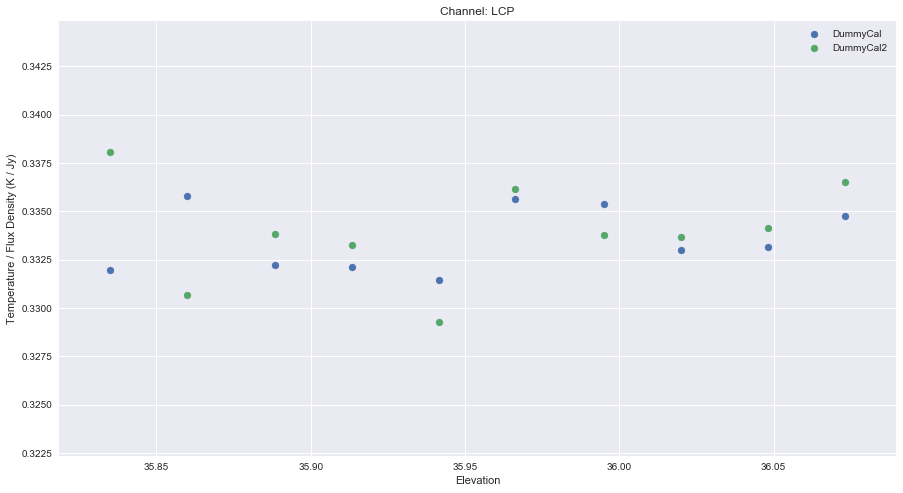

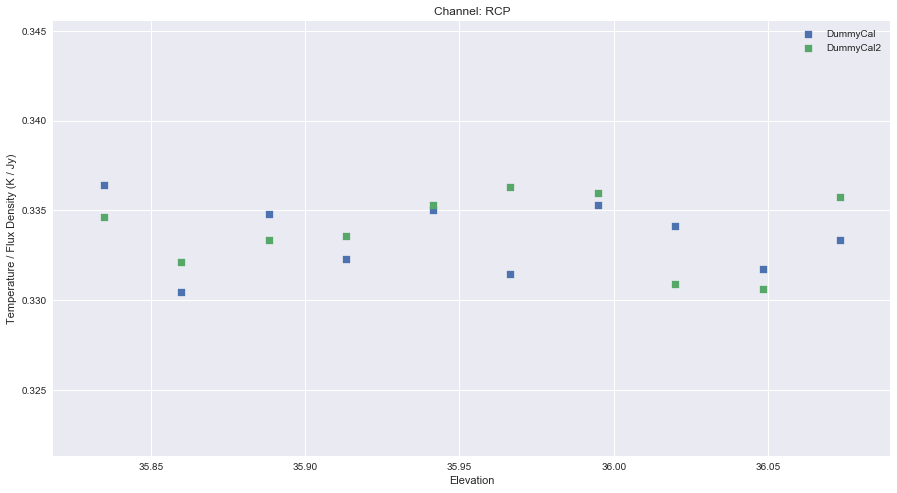

In [11]:
plt.figure(figsize=(15, 8))
good = (table['Source'] == 'DummyCal')&(table['Chan'] == 'Feed0_LCP')
plt.scatter(table['Elevation'][good], table['Flux/T'][good],
            label='DummyCal', marker='o')
good = (table['Source'] == 'DummyCal2')&(table['Chan'] == 'Feed0_LCP')
plt.scatter(table['Elevation'][good], table['Flux/T'][good],
            label='DummyCal2', marker='o')

plt.title('Channel: LCP')
plt.xlabel('Elevation')
plt.ylabel('Temperature / Flux Density (K / Jy)')
plt.legend()

plt.figure(figsize=(15, 8))
good = (table['Source'] == 'DummyCal')&(table['Chan'] == 'Feed0_RCP')
plt.scatter(table['Elevation'][good], table['Flux/T'][good],
            label='DummyCal', marker='s')
good = (table['Source'] == 'DummyCal2')&(table['Chan'] == 'Feed0_RCP')
plt.scatter(table['Elevation'][good], table['Flux/T'][good],
            label='DummyCal2', marker='s')

plt.title('Channel: RCP')
plt.xlabel('Elevation')
plt.ylabel('Temperature / Flux Density (K / Jy)')
plt.legend()


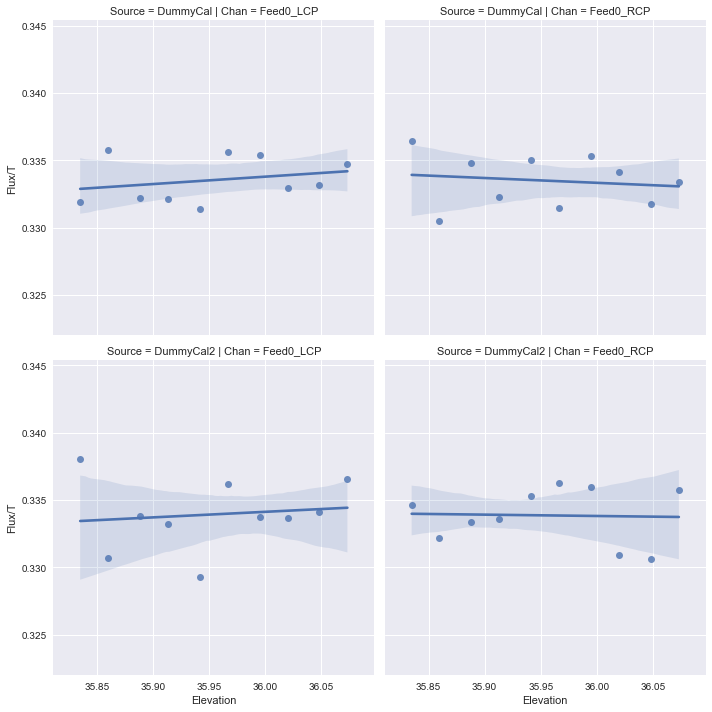

In [12]:
fig = plt.figure(figsize=(15., 8))
g = lmplot(x="Elevation", y="Flux/T", row='Source', col='Chan',
           truncate=True, size=5, data=table)

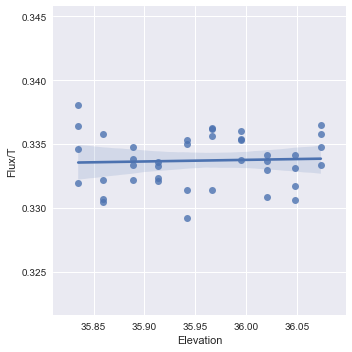

In [13]:
fig = plt.figure(figsize=(15., 8))
g = lmplot(x="Elevation", y="Flux/T",
           truncate=True, data=table)

But we can do everything we want with that information... For example a pairplot

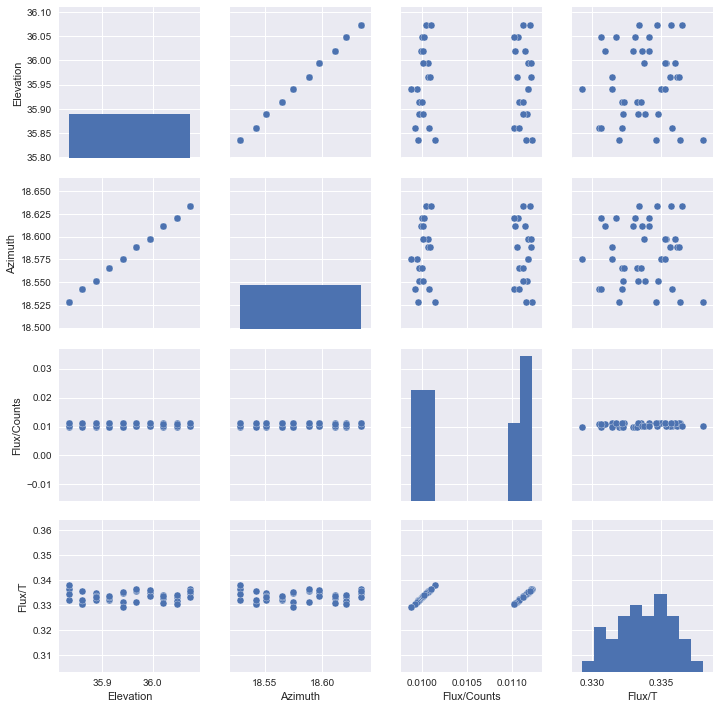

In [14]:
pairplot(table, vars=['Elevation', 'Azimuth', 'Flux/Counts', 'Flux/T'])

# Create map

This is done with `SDTimage`. WCS coordinates are automatically calculated and results are written into a `ds9`- and `casaviewer`-compatible FITS file.

To visualize, I'm using the `aplpy` library here.

In [15]:
!SDTimage -c CCB_TP_Dummy_Obs0.ini --sub

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 7 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 59 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 3 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 3 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srtt

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 4 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 39 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 22 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 6 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 4 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 4 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 14 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 13 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 5 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1012-py3.6.egg/srttools/fit.py:326: UserWarning: Found 4 outliers
  UserWarning)


INFO: Auto-setting vmin to -1.302e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.438e+03 [aplpy.core]


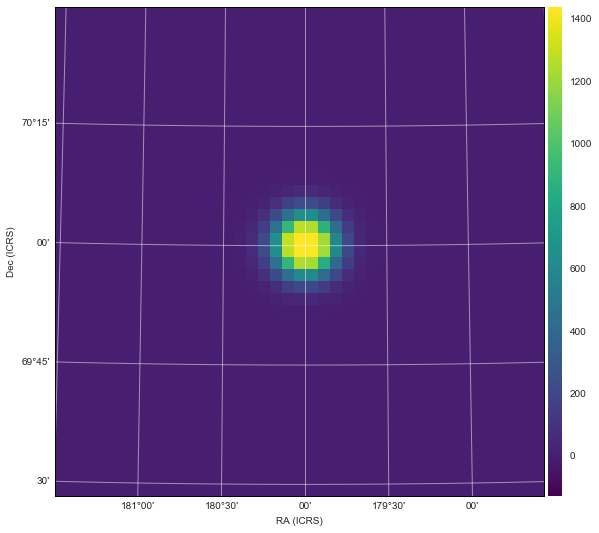

In [16]:
gc = aplpy.FITSFigure('CCB_TP_Dummy_Obs0.fits', hdu=1)
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()
gc.add_grid()

INFO: Auto-setting vmax to  1.295e+03 [aplpy.core]


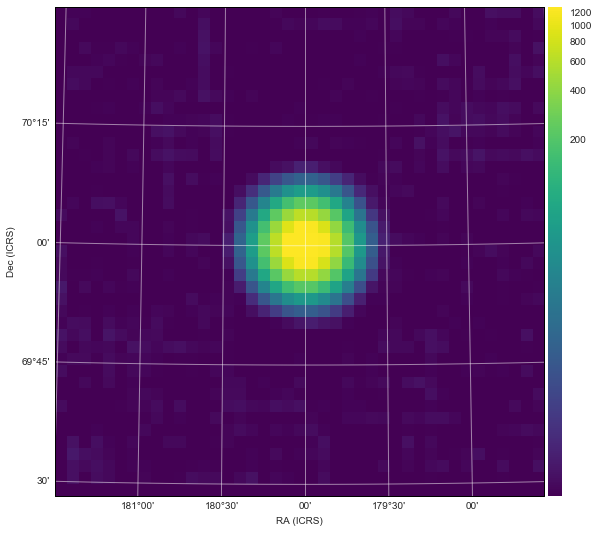

In [17]:
gc = aplpy.FITSFigure('CCB_TP_Dummy_Obs0.fits', hdu=1)
gc.show_colorscale(cmap='viridis', stretch='log', vmin=1e-3)
gc.add_colorbar()

gc.add_grid()

# Interactive filtering

We can cleanup the scans interactively. A window opens and we can point and click to select all scans passing through a pixel, and flag bad scans, zap intervals, redo baseline fitting, etc.

In [18]:
!SDTimage -c CCB_TP_Dummy_Obs0.ini --sub --interactive

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
402/402
        -------------------------------------------------------------

        Imageactive display.

        -------------------------------------------------------------

        Point the mouse on a pixel in the STDDEV image and press a key:

        a    open a window to filter all scans passing through this pixel
        h    print help
        q    quit

        -------------------------------------------------------------
        
(20.913306451612904, 21.30016129032258, 'a')

-------------------------------------------------------------

Interactive plotter.

-------------------------------------------------------------

Choose line to fit: Click on the li

# Calibrate the image

Now we can calibrate the image, using the calibration calculated above, using the option `--calibrate <CALFILE>.hdf5` and specifying the unit (Jy/beam, Jy/pixel, or Jy/sterad) with `-u <UNIT>` 

Note: instead of the calibration file, we can give the HDF5 file dumped by `SDTimage` in the previous processing.

In [19]:
!SDTimage -c CCB_TP_Dummy_Obs0.ini -u 'Jy/beam' --sub --calibrate CCB_TP_Dummy_Obs0_cal.hdf5

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO: Auto-setting vmin to -1.030e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.204e+00 [aplpy.core]


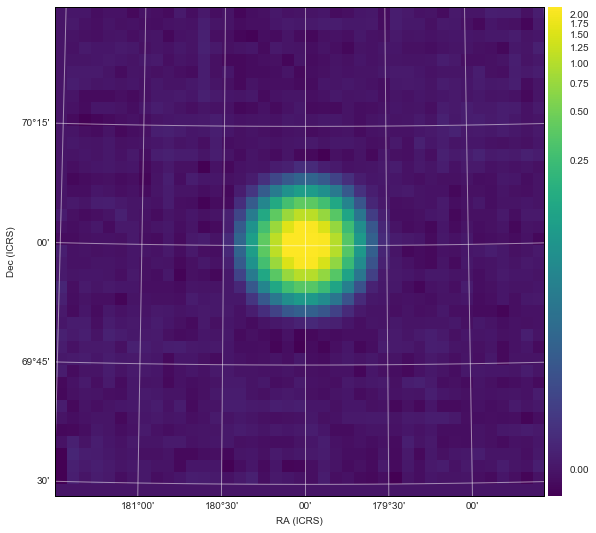

In [20]:
gc = aplpy.FITSFigure('CCB_TP_Dummy_Obs0_cal.fits', hdu=1)
gc.show_colorscale(cmap='viridis', stretch='log')
gc.add_colorbar()
gc.add_grid()